In [1]:
import os
import random
import codecs

import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from sklearn.feature_extraction import text as text_fe
from sklearn import svm
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
import tqdm

In [2]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

SEED = 42
set_seed(SEED)

In [3]:
words = [
    'кінь', 'зебра', 'корова', 'ведмідь', 'олень', 
    'страус', 'курка', 'пінгвін', 'сова', 'лебідь', 
    'морквина', 'яблуко', 'банан', 'картопля', 'лимон'
]

In [4]:
uk_letters = set('абвгґдеєжзиіїйклмнопрстуфхцчшщьюя')

# Load embedding

In [4]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.uk.vec

--2020-10-14 14:45:43--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.uk.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2397609914 (2.2G) [binary/octet-stream]
Saving to: ‘wiki.uk.vec’

wiki.uk.vec         100%[===================>]   2.23G  12.6MB/s    in 3m 4s   

2020-10-14 14:48:48 (12.5 MB/s) - ‘wiki.uk.vec’ saved [2397609914/2397609914]



In [5]:
embeddings_index = {}
f = codecs.open('wiki.uk.vec', encoding='utf-8')
for line in tqdm.tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    if not(set(word) - uk_letters):
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

912461it [01:53, 8055.89it/s]

found 669366 word vectors


# Create embedding matrix

In [6]:
print('preparing embedding matrix...')
nb_words = len(embeddings_index) + 1
all_word_list = ['<OOV>']
embedding_matrix = np.zeros((nb_words, 300))
for ind, (word, values) in enumerate(embeddings_index.items(), 1):
    embedding_matrix[ind] = values
    all_word_list.append(word)

preparing embedding matrix...


# Read and process data

In [23]:
data = pd.read_csv('index.csv', index_col=0)
print(data.shape)
# data_aug = pd.read_csv('resources/data_augment_ua_en_cn_en_ua.csv', index_col=0)
# print(data_aug.shape)
# data = pd.concat([data, data_aug])
# print(data.shape)
# data.head()

(165, 3)


In [24]:
data['description'] = data['description'].str.lower()
data['description'] = data['description'].str.replace("’", "'")
data['description'] = data['description'].str.replace("'", "")

for s in '!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n«»’':
    data['description'] = data['description'].str.replace(s, "")
for s in '-':
    data['description'] = data['description'].str.replace(s, " ")

In [25]:
train_data = data[data['user'] <= 5].copy()
valid_data = data[(data['user'] >= 6) & (data['user'] <= 7)].copy()
test_data = data[data['user'] > 7].copy()

In [26]:
embedding_dim = 300
max_length = 30
trunc_type='post'
padding_type='pre'

# Tokeize data

In [27]:
def get_X_y(data, train=1):
    X = []
    for row in data['description'].str.split():
        X.append([])
        for item in row:
            try: 
                ind = all_word_list.index(item)
            except:
                print('Not in the tokenizer: ', item)
                ind = 0
            X[-1].append(ind)
    X = np.array(X)
    X = pad_sequences(X, padding=padding_type, maxlen=max_length)
    if train:
        y = data['word'].apply(lambda x: words.index(x))
    else:
        y = data['word'].apply(lambda x: words.index(x))
    return X, y

In [28]:
X_train, y_train = get_X_y(train_data, 1)
X_valid, y_valid = get_X_y(valid_data, 1)
X_test, y_test = get_X_y(test_data, 0)

Not in the tokenizer:  парнокопитної
Not in the tokenizer:  подужче
Not in the tokenizer:  півметровий
Not in the tokenizer:  солодкувата
Not in the tokenizer:  визріє
Not in the tokenizer:  копитна
Not in the tokenizer:  копитна
Not in the tokenizer:  вимям
Not in the tokenizer:  мичить
Not in the tokenizer:  360
Not in the tokenizer:  гичку
Not in the tokenizer:  5
Not in the tokenizer:  13
Not in the tokenizer:  девятнадцятого
Not in the tokenizer:  смуглястий
Not in the tokenizer:  кудахкає
Not in the tokenizer:  ниряє
Not in the tokenizer:  перевальцем
Not in the tokenizer:  кератином
Not in the tokenizer:  підковують
Not in the tokenizer:  подовгуватий
Not in the tokenizer:  подовгастий
Not in the tokenizer:  подовгуватий
Not in the tokenizer:  360
Not in the tokenizer:  парнокопитний
Not in the tokenizer:  бігучий
Not in the tokenizer:  нелетючий
Not in the tokenizer:  мякоті
Not in the tokenizer:  мякоттю


# Build and train model

In [29]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            nb_words, 
            300, 
            weights=[embedding_matrix], 
            input_length=max_length, 
            trainable=False
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64)
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(15, activation='softmax')
    ])
    model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           200810100 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1935      
Total params: 200,998,915
Trainable params: 188,815
Non-trainable params: 200,810,100
_________________________________________________________________


In [30]:
checkpoint_save = callbacks.ModelCheckpoint(
    'best-model.hdf5',
     monitor='val_loss', 
     verbose=1, 
     save_best_only=True,
     save_weights_only=False, 
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=30, 
    validation_data=(X_valid, y_valid), 
    batch_size=8,
    # callbacks=[
    #     checkpoint_save,
    # ],
    verbose=1
)

Epoch 1/30
10/10 [==============================] - 1s 100ms/step - loss: 2.7528 - accuracy: 0.0800 - val_loss: 2.6771 - val_accuracy: 0.1000
Epoch 2/30
10/10 [==============================] - 0s 18ms/step - loss: 2.5837 - accuracy: 0.2000 - val_loss: 2.6398 - val_accuracy: 0.1333
Epoch 3/30
10/10 [==============================] - 0s 18ms/step - loss: 2.4667 - accuracy: 0.3067 - val_loss: 2.5801 - val_accuracy: 0.2000
Epoch 4/30
10/10 [==============================] - 0s 17ms/step - loss: 2.3095 - accuracy: 0.5067 - val_loss: 2.4834 - val_accuracy: 0.1667
Epoch 5/30
10/10 [==============================] - 0s 18ms/step - loss: 2.1393 - accuracy: 0.5867 - val_loss: 2.3341 - val_accuracy: 0.2667
Epoch 6/30
10/10 [==============================] - 0s 18ms/step - loss: 1.7451 - accuracy: 0.7733 - val_loss: 2.0879 - val_accuracy: 0.3333
Epoch 7/30
10/10 [==============================] - 0s 18ms/step - loss: 1.4740 - accuracy: 0.7467 - val_loss: 1.8966 - val_accuracy: 0.5000
Epoch 8/30
1

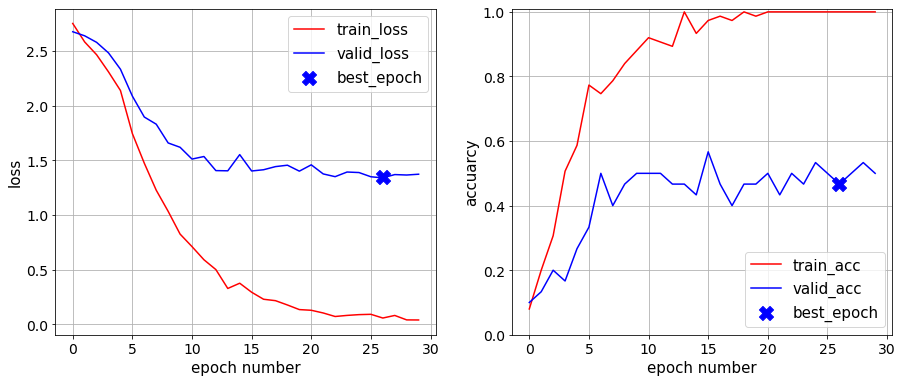

In [69]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='red', label='train_loss')
plt.plot(history.history['val_loss'], color='blue', label='valid_loss')
plt.scatter([26], [1.35], color='blue', s=200, label='best_epoch', marker='X')
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('epoch number', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='red', label='train_acc')
plt.plot(history.history['val_accuracy'], color='blue', label='valid_acc')
plt.scatter([26], [0.4677], color='blue', s=200, label='best_epoch', marker='X')
plt.legend(fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('epoch number', fontsize=15)
plt.ylabel('accuarcy', fontsize=15)
plt.ylim(0, 1.01)
plt.grid()

# Confusion matrix

0.7333333333333333


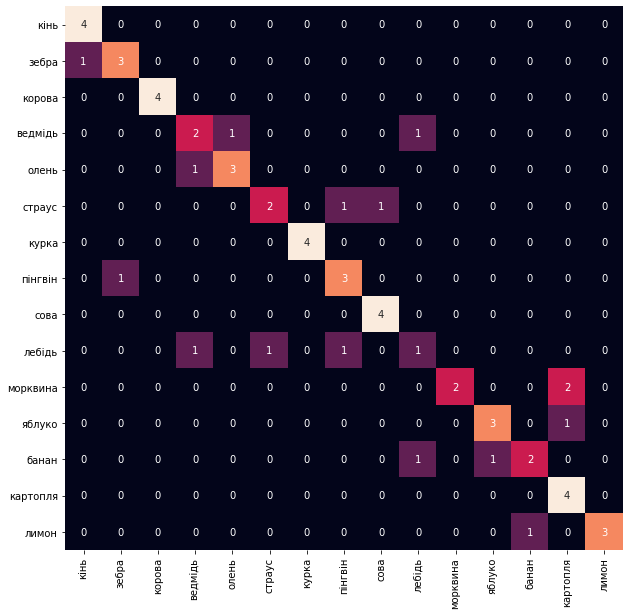

In [36]:
res = model.predict(X_test).argmax(axis=1)
print(metrics.accuracy_score(y_test, res))
m = metrics.confusion_matrix(y_test, res)
df_cm = pd.DataFrame(m, index = words, columns = words)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True, cbar=False)

# Not predicted data

In [38]:
test_data['pred'] = res
test_data['real'] = y_test
no_ok = test_data[test_data['pred'] != test_data['real']]
for i in range(no_ok.shape[0]):
    print(no_ok.iloc[i]['description'], '|', no_ok.iloc[i]['word'], '|', words[no_ok.iloc[i]['pred']])

тварина яка має гриву але не кінь | зебра | кінь
цим звіром нарікають людей які чогось не розуміють | олень | ведмідь
птах який живе на північному полюсі темно синього кольору з білим животом | пінгвін | зебра
овоч який дуже полюбляють зайці конусної форми | морквина | картопля
подовгуватий фрукт який їдять в очищеному вигляді без шкірки | банан | яблуко
жовтий овальний на вигляд фрукт | лимон | банан
дика всеїдна тварина може жити в лісі і мати коричневе хутро або на північному полюсі і мат біле хутро | ведмідь | лебідь
зазвичай біла птиця з довгою шиєю часто ж символом кохання | лебідь | пінгвін
великий птах що не вміє літати але може швидко бігати часто можна бачити в зоопарку | страус | пінгвін
красивий птах білого кольору має довгу шию часто можна бачити в зоопарку | лебідь | страус
великий хижий ссавець тварина з довгою шерстю і товстими ногами | ведмідь | олень
найбільший бігучий нелетючий птах жарких країн з красивим оперенням | страус | сова
велика водоплавна птиця з довгою зі